In [1]:
! pip install jupyter openpyxl seaborn matplotlib
! pip install -U sentence-transformers

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.6/120.6 KB 1.9 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.7/65.7 KB 5.5 MB/s eta 0:00:00
Defaulting to user installation because normal site-packages is not writeable


In [76]:
import datetime
import os
import sys
from pathlib import Path

import numpy as np

print(f"UTC now= '{datetime.datetime.utcnow().isoformat().split('.')[0]}'")

print(f'Virtualenv used: {sys.executable}')

import pandas as pd
import ast
import pickle

from sklearn.cluster import KMeans


from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn import metrics

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import seaborn as sns
import matplotlib.pyplot as plt

from sentence_transformers import SentenceTransformer, util

from sklearn.preprocessing import MinMaxScaler


UTC now= '2022-04-30T19:27:46'
Virtualenv used: /usr/bin/python3


In [45]:
def _save_pandas_pickle(df, outfile, results_folder):
  if results_folder:
    results_folder_local = f"{str(Path('~').expanduser().resolve())}/{results_folder}"
    # results_folder_local = results_folder
  else:
    results_folder_local = f"{str(Path('~').expanduser().resolve())}/data"
  Path(results_folder_local).mkdir(parents=True, exist_ok=True)
  fname = f"{results_folder_local}/{outfile}.pickle"
  print(fname)
  # df.to_pickle(fname)
  with open(fname, 'wb') as f:
    pickle.dump(df, f)

In [2]:
# df_nodes = pd.read_excel('/media/mmozolewski/m.mozolewski@gma/Documents/Doktorat/Parisa/xai-survey/RC6 nodes info(Abstract).xlsx', sheet_name=0)
# df_edges = pd.read_excel('/media/mmozolewski/m.mozolewski@gma/Documents/Doktorat/Parisa/xai-survey/Data.xlsx', sheet_name=0)
df_nodes = pd.read_excel('notebooks/xai-survey/RC6 nodes info(Abstract).xlsx', sheet_name=0)
df_edges = pd.read_excel('notebooks/xai-survey/Data.xlsx', sheet_name=0)

In [4]:
df_nodes[['ID', 'Title', 'Abstract', 'CitationCount', 'RepetitionCount']]

,ID,Title,Abstract,CitationCount,RepetitionCount
0,1,"""Why Should I Trust You?"": Explaining the Pred...","Despite widespread adoption, machine learning ...",5799,17
1,2,On Pixel-Wise Explanations for Non-Linear Clas...,Understanding and interpreting classification ...,1848,15
2,4,A Unified Approach to Interpreting Model Predi...,Understanding why a model makes a certain pred...,3798,13
3,5,Axiomatic Attribution for Deep Networks,We study the problem of attributing the predic...,1749,13
4,7,Visualizing and Understanding Convolutional Ne...,Large Convolutional Network models have recent...,10818,11
5,8,Deep Inside Convolutional Networks: Visualisin...,This paper addresses the visualisation of imag...,3895,11
6,9,Grad-CAM: Visual Explanations from Deep Networ...,We propose a technique for producing ‘visual e...,3827,11
7,11,Understanding Black-box Predictions via Influe...,How can we explain the predictions of a black-...,1268,11
8,12,Anchors: High-Precision Model-Agnostic Explana...,We introduce a novel model-agnostic system tha...,746,11
9,13,How to Explain Individual Classification Decis...,After building a classifier with modern tools ...,655,10


In [5]:
df_nodes.loc[df_nodes['Abstract'].isna(), ]

,ID,Title,Year,CitationCount,RepetitionCount,Abstract
28,36,Feature Visualization,1994,513,6,NaN


In [6]:
df_edges.loc[(df_edges['node 1']==36) | (df_edges['node 2']==36), ]

,node 1,node 2,link type
148,50,36,['methodology']


In [3]:
# print(df_edges['link type'].dtype)
# df_edges.loc[32, 'link type'][0]
# ast.literal_eval(df_edges.loc[32, 'link type'])
df_edges['link type'] = df_edges['link type'].apply(lambda x: "['unknown']" if x == "[]" else x)
df_edges['link type'] = df_edges['link type'].apply(lambda x: ast.literal_eval(x))
df_edges

,node 1,node 2,link type
0,9,1,[unknown]
1,15,1,[unknown]
2,49,2,[unknown]
3,2,7,[unknown]
4,5,7,[unknown]
...,...,...,...
153,35,51,[methodology]
154,51,2,[result]
155,50,7,[result]
156,51,19,[result]


In [ ]:
# Plan :
# 4 relacje
# 50 artów
#
# id | is_methodology_01 | is_result_01 | is_result_01 |
# 00       true                false

# Opcja: SVD (LSA) -> jak PCA, TF-IDF
# Normalizacja
# k-means
# KnAC (objaśnienia na abstraktach)

In [4]:
df_edges_flatten = []
for index, row in df_edges.iterrows():
  for link_type in row['link type']:
    df_edges_flatten.append((f"{row['node 1']:02d}", f"{row['node 2']:02d}_{link_type}", row['node 1'], row['node 2'], link_type))
df_edges_flatten = pd.DataFrame(df_edges_flatten)
df_edges_flatten.sort_values(by=[2, 3, 4], inplace=True)
df_edges_flatten

,0,1,2,3,4
152,01,13_background,1,13,background
154,01,13_methodology,1,13,methodology
153,01,13_result,1,13,result
72,01,20_background,1,20,background
73,01,20_methodology,1,20,methodology
...,...,...,...,...,...
112,52,16_background,52,16,background
113,52,16_methodology,52,16,methodology
178,52,19_background,52,19,background
120,52,25_background,52,25,background


In [5]:
# pd.pivot_table(df_edges_flatten, index=0, values=2, columns=1, aggfunc='-'.join)
df_edges_flatten_one_hot = pd.get_dummies(df_edges_flatten[1])
df_edges_flatten_one_hot = pd.concat([df_edges_flatten, df_edges_flatten_one_hot], axis=1, join="inner")
df_edges_flatten_one_hot

,0,1,2,3,4,01_background,01_methodology,01_result,01_unknown,02_background,...,45_methodology,46_background,46_methodology,49_background,49_methodology,49_unknown,51_background,51_methodology,52_background,52_methodology
152,01,13_background,1,13,background,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
154,01,13_methodology,1,13,methodology,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
153,01,13_result,1,13,result,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
72,01,20_background,1,20,background,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
73,01,20_methodology,1,20,methodology,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,52,16_background,52,16,background,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
113,52,16_methodology,52,16,methodology,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
178,52,19_background,52,19,background,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
120,52,25_background,52,25,background,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## One-hot features

In [6]:
df_edges_one_hot = df_edges_flatten_one_hot.groupby(0).agg(lambda x: x.sum()).reset_index()
df_edges_one_hot.rename(columns={0: "article_which_cities"}, inplace=True)
del df_edges_one_hot[1]
del df_edges_one_hot[2]
del df_edges_one_hot[3]
del df_edges_one_hot[4]
df_edges_one_hot['cluster_kmeans'] = -1
df_edges_one_hot

,article_which_cities,01_background,01_methodology,01_result,01_unknown,02_background,02_methodology,02_result,02_unknown,04_methodology,...,46_background,46_methodology,49_background,49_methodology,49_unknown,51_background,51_methodology,52_background,52_methodology,cluster_kmeans
0,01,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1
1,02,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1
2,04,0,1,0,0,0,1,0,0,0,...,0,1,1,1,0,0,0,0,0,-1
3,05,1,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,-1
4,07,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1
5,08,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1
6,09,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1
7,11,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,-1
8,12,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1
9,13,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1


## LSA features on One-HOT

In [13]:
def get_LSA(df, column_to_ommit, how_many_dimmension):
  svd = TruncatedSVD(how_many_dimmension) # >~ 70%
  normalizer = Normalizer(copy=False)
  lsa = make_pipeline(svd, normalizer)

  df_edges_lsa = pd.DataFrame(lsa.fit_transform(df.loc[:, df.columns != column_to_ommit]))
  print(f"explained variance perc = {svd.explained_variance_ratio_.sum()*100}%")

  df_edges_lsa = pd.concat([df['article_which_cities'], df_edges_lsa], axis=1, join="inner")
  df_edges_lsa['cluster_kmeans'] = -1
  return df_edges_lsa

df_edges_lsa = get_LSA(df_edges_one_hot, 'article_which_cities', 10)
df_edges_lsa

explained variance perc = 68.36623138055718%


,article_which_cities,0,1,2,3,4,5,6,7,8,9,cluster_kmeans
0,01,0.343058,0.191082,-0.624564,-0.404632,0.265121,0.056131,0.166706,-0.401479,0.157886,0.068168,-1
1,02,0.815231,-0.232352,-0.171702,0.148767,-0.351675,-0.168126,-0.196812,-0.054942,-0.184832,0.044034,-1
2,04,0.548787,0.175925,-0.251816,0.117570,-0.049211,0.047638,0.522121,0.138306,-0.153252,0.520320,-1
3,05,0.620934,-0.168509,-0.452865,0.221894,0.386291,0.043533,-0.361478,0.099688,-0.081714,-0.182552,-1
4,07,0.827489,-0.052992,-0.221515,-0.129238,-0.330055,-0.245073,-0.211580,-0.177083,0.017485,0.035426,-1
5,08,0.707350,-0.026099,0.089920,-0.394908,-0.470637,0.106166,0.156129,0.197436,0.133955,-0.144446,-1
6,09,0.603950,-0.116982,-0.310796,0.473035,-0.170714,-0.401964,-0.218627,-0.073637,0.132451,-0.199301,-1
7,11,0.808194,0.134994,-0.248544,0.150935,-0.001123,-0.283729,-0.299077,0.104645,0.249237,-0.031979,-1
8,12,0.456724,0.347614,-0.489292,-0.306305,0.452035,-0.017112,0.141685,-0.041261,0.312035,0.116478,-1
9,13,0.572780,0.081360,-0.342576,-0.373031,-0.477693,-0.332569,-0.036609,-0.109448,-0.150014,0.184869,-1


## Sentence-BERT embeddings

In [9]:
model = SentenceTransformer('distiluse-base-multilingual-cased-v1')

In [10]:
df_edges_bert = pd.DataFrame(model.encode(df_nodes['Abstract'].tolist()))
df_edges_bert.head(3)

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
0,-0.000553,-0.018878,0.005200,-0.041082,0.105269,-0.045668,0.038578,-0.008916,0.023942,0.011202,...,-0.017968,-0.006445,0.014152,-0.011385,-0.030502,-0.032760,-0.005807,-0.049921,-0.027134,-0.033042
1,0.054277,-0.006851,0.035458,-0.003538,0.082228,-0.095527,0.015141,-0.038575,0.026256,0.019794,...,-0.013977,0.081980,0.005427,-0.013312,-0.030893,-0.063076,-0.121146,-0.068730,-0.013837,0.066910
2,0.004317,-0.004644,-0.024705,-0.030372,0.107849,-0.061204,0.031549,0.002038,0.017995,-0.029178,...,-0.015788,0.013097,-0.027097,-0.008309,-0.052290,-0.009791,-0.062663,-0.008897,-0.041519,-0.012917


In [11]:
df_edges_bert = pd.concat([df_edges_one_hot['article_which_cities'], df_edges_bert], axis=1, join="inner")
df_edges_bert['cluster_kmeans'] = -1
df_edges_bert

,article_which_cities,0,1,2,3,4,5,6,7,8,...,503,504,505,506,507,508,509,510,511,cluster_kmeans
0,01,-0.000553,-0.018878,0.005200,-0.041082,0.105269,-0.045668,0.038578,-0.008916,0.023942,...,-0.006445,0.014152,-0.011385,-0.030502,-0.032760,-0.005807,-0.049921,-0.027134,-0.033042,-1
1,02,0.054277,-0.006851,0.035458,-0.003538,0.082228,-0.095527,0.015141,-0.038575,0.026256,...,0.081980,0.005427,-0.013312,-0.030893,-0.063076,-0.121146,-0.068730,-0.013837,0.066910,-1
2,04,0.004317,-0.004644,-0.024705,-0.030372,0.107849,-0.061204,0.031549,0.002038,0.017995,...,0.013097,-0.027097,-0.008309,-0.052290,-0.009791,-0.062663,-0.008897,-0.041519,-0.012917,-1
3,05,0.002560,0.011128,0.002151,-0.024552,0.079729,-0.009693,-0.009770,0.028755,0.055328,...,0.002256,-0.027147,-0.051365,0.013915,-0.016082,-0.065891,0.041484,-0.002915,0.015306,-1
4,07,-0.049904,-0.009731,-0.050840,-0.033299,0.073338,-0.043489,-0.058084,-0.011454,0.028668,...,0.030507,0.011908,-0.010923,-0.059956,-0.027306,-0.058569,0.014828,-0.011092,0.021681,-1
5,08,-0.025868,-0.004474,0.027387,-0.018476,0.076490,-0.055742,0.041232,0.032145,-0.016426,...,0.035038,-0.006214,-0.074798,-0.006485,-0.024918,-0.050014,-0.050590,-0.018540,0.013127,-1
6,09,0.010309,-0.033658,0.040180,-0.021090,0.075706,-0.020667,0.042318,0.038162,-0.000312,...,0.008208,-0.000204,-0.066119,-0.032306,-0.034639,-0.069052,0.025285,-0.013056,0.029847,-1
7,11,0.003816,0.001510,0.044903,-0.035133,0.046942,-0.032139,0.043377,-0.005317,-0.006181,...,0.016284,0.002833,-0.001493,-0.015539,-0.015297,-0.023632,-0.036976,-0.023497,-0.007580,-1
8,12,0.016873,0.012663,0.041604,-0.033831,0.044544,-0.062096,-0.020983,0.005886,0.056358,...,-0.008711,-0.045702,0.056886,-0.024806,-0.036273,-0.058977,-0.028191,-0.018777,-0.025684,-1
9,13,-0.018026,-0.025824,0.050376,-0.038768,0.071750,-0.027621,0.055036,0.018378,0.031026,...,0.037017,0.034202,-0.028098,-0.037571,-0.024671,-0.040424,-0.024535,0.003050,0.033438,-1


# LSA features on Sentence-BERT embeddings

In [139]:
df_edges_bert_lsa = get_LSA(df_edges_bert, 'article_which_cities', 4)
df_edges_bert_lsa

explained variance perc = 70.66570967004722%


,article_which_cities,0,1,2,3,cluster_kmeans
0,01,0.992611,-0.091498,0.012865,0.078657,-1
1,02,0.934075,0.200135,-0.090387,0.281568,-1
2,04,0.991836,-0.095138,-0.055533,-0.064237,-1
3,05,0.311671,0.866545,-0.357139,0.156243,-1
4,07,0.251106,0.862389,-0.436455,-0.052328,-1
5,08,0.197936,0.789310,-0.581211,0.002188,-1
6,09,0.240538,0.911426,-0.326223,-0.070874,-1
7,11,0.988442,-0.092839,-0.055476,0.106236,-1
8,12,0.995011,-0.080870,-0.051787,0.027050,-1
9,13,0.993148,-0.062575,-0.012137,0.097954,-1


# K-means clustering

In [140]:
def k_means(df, column_to_ommit, how_many_clusters):
  kmeans = KMeans(n_clusters=how_many_clusters, random_state=2022).fit(df.loc[:, (df.columns != column_to_ommit) & (df.columns != 'cluster_kmeans')])
  # kmeans.labels_
  # print(pd.DataFrame(kmeans.cluster_centers_).reset_index())
  # print(pd.DataFrame(kmeans.cluster_centers_).reset_index()['index'])
  df['cluster_kmeans'] = kmeans.labels_
  # df_only_one_hots = df.loc[:, (df.columns != 'article_which_cities') & (df.columns != 'cluster_kmeans')]
  # df[['article_which_cities', 'cluster_kmeans']]
  return df

df_edges_one_hot = k_means(df_edges_one_hot, 'article_which_cities', 3)
df_edges_lsa = k_means(df_edges_lsa, 'article_which_cities', 3)
df_edges_bert = k_means(df_edges_bert, 'article_which_cities', 3)
df_edges_bert_lsa = k_means(df_edges_bert_lsa, 'article_which_cities', 3)

In [141]:
def get_TSNE_and_PCA_embeddings(df_edges, column_to_ommit):
  df_edges_independent_vars = df_edges.loc[:, (df_edges.columns != column_to_ommit) & (df_edges.columns != 'cluster_kmeans')]

  df_tsne = pd.DataFrame(TSNE(n_components=2).fit_transform(df_edges_independent_vars))
  df_tsne['cluster'] = df_edges['cluster_kmeans']
  df_tsne.columns = ['x1', 'x2', 'cluster']
  df_tsne['article_which_cities'] = df_edges['article_which_cities']

  df_pca = pd.DataFrame(PCA(n_components=2).fit_transform(df_edges_independent_vars))
  df_pca['cluster'] = df_edges['cluster_kmeans']
  df_pca.columns = ['x1', 'x2', 'cluster']
  df_pca['article_which_cities'] = df_edges['article_which_cities']

  scaler = MinMaxScaler()
  df_tsne[['x1', 'x2']] = scaler.fit_transform(df_tsne[['x1', 'x2']])
  df_pca[['x1', 'x2']] = scaler.fit_transform(df_pca[['x1', 'x2']])

  return df_tsne, df_pca

df_tsne_one_hots, df_pca_one_hots = get_TSNE_and_PCA_embeddings(df_edges_one_hot, 'article_which_cities')
df_tsne_lsa, df_pca_lsa = get_TSNE_and_PCA_embeddings(df_edges_lsa, 'article_which_cities')
df_tsne_bert, df_pca_bert = get_TSNE_and_PCA_embeddings(df_edges_bert, 'article_which_cities')
df_tsne_bert_lsa, df_pca_bert_lsa = get_TSNE_and_PCA_embeddings(df_edges_bert_lsa, 'article_which_cities')

In [143]:
_save_pandas_pickle(df_tsne_one_hots, 'df_tsne_one_hots', "notebooks/xai-survey/clusters-embeddings")
_save_pandas_pickle(df_pca_one_hots, 'df_pca_one_hots', "notebooks/xai-survey/clusters-embeddings")
_save_pandas_pickle(df_tsne_lsa, 'df_tsne_lsa', "notebooks/xai-survey/clusters-embeddings")
_save_pandas_pickle(df_pca_lsa, 'df_pca_lsa', "notebooks/xai-survey/clusters-embeddings")
_save_pandas_pickle(df_tsne_bert, 'df_tsne_bert', "notebooks/xai-survey/clusters-embeddings")
_save_pandas_pickle(df_pca_bert, 'df_pca_bert', "notebooks/xai-survey/clusters-embeddings")
_save_pandas_pickle(df_tsne_bert_lsa, 'df_tsne_bert_lsa', "notebooks/xai-survey/clusters-embeddings")
_save_pandas_pickle(df_pca_bert_lsa, 'df_pca_bert_lsa', "notebooks/xai-survey/clusters-embeddings")

/home/mmozolewski/notebooks/xai-survey/clusters-embeddings/df_tsne_one_hots.pickle
/home/mmozolewski/notebooks/xai-survey/clusters-embeddings/df_pca_one_hots.pickle
/home/mmozolewski/notebooks/xai-survey/clusters-embeddings/df_tsne_lsa.pickle
/home/mmozolewski/notebooks/xai-survey/clusters-embeddings/df_pca_lsa.pickle
/home/mmozolewski/notebooks/xai-survey/clusters-embeddings/df_tsne_bert.pickle
/home/mmozolewski/notebooks/xai-survey/clusters-embeddings/df_pca_bert.pickle
/home/mmozolewski/notebooks/xai-survey/clusters-embeddings/df_tsne_bert_lsa.pickle
/home/mmozolewski/notebooks/xai-survey/clusters-embeddings/df_pca_bert_lsa.pickle


Text(0.5, 0.98, 'Clustering result: citations data (One-Hot, LSA) \n (visualized using TSNE2D vs. PCA2D)')

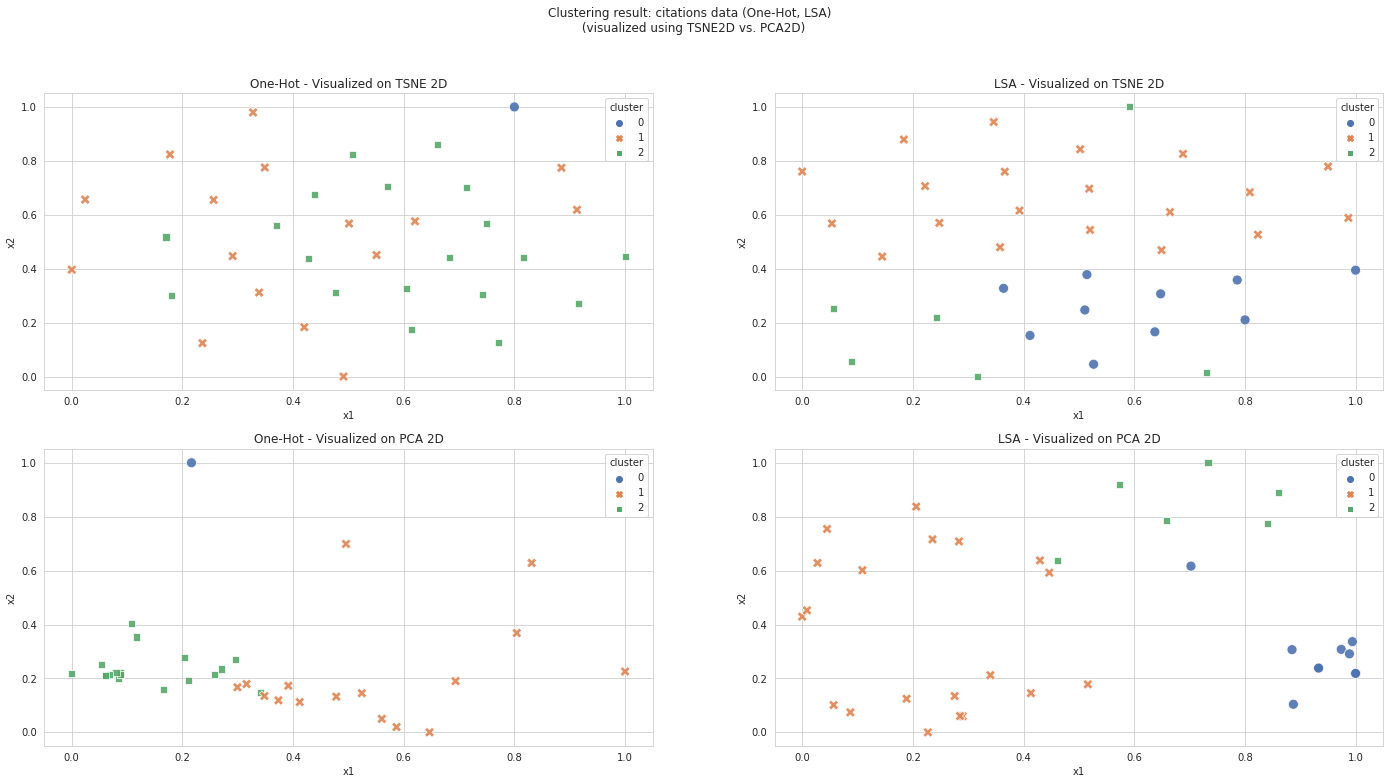

In [110]:
fig, ax = plt.subplots(2, 2, figsize=(12*2,6*2))
sns.scatterplot(data=df_tsne_one_hots, x='x1', y='x2', hue='cluster', style='cluster', legend="full", alpha=0.9, palette="deep", s=100, ax=ax[0,0])
ax[0,0].set_title('One-Hot - Visualized on TSNE 2D')
sns.scatterplot(data=df_tsne_lsa, x='x1', y='x2', hue='cluster', style='cluster', legend="full", alpha=0.9, palette="deep", s=100, ax=ax[0,1])
ax[0,1].set_title('LSA - Visualized on TSNE 2D')
# sns.scatterplot(data=df_tsne_bert, x='x1', y='x2', hue='cluster', style='cluster', legend="full", alpha=0.9, palette="deep", s=100, ax=ax[0,2])
# ax[0,2].set_title('** BERT - Visualized on TSNE 2D')

sns.scatterplot(data=df_pca_one_hots, x='x1', y='x2', hue='cluster', style='cluster', legend="full", alpha=0.9, palette="deep", s=100, ax=ax[1,0])
ax[1,0].set_title('One-Hot - Visualized on PCA 2D')
sns.scatterplot(data=df_pca_lsa, x='x1', y='x2', hue='cluster', style='cluster', legend="full", alpha=0.9, palette="deep", s=100, ax=ax[1,1])
ax[1,1].set_title('LSA - Visualized on PCA 2D')
# sns.scatterplot(data=df_pca_bert, x='x1', y='x2', hue='cluster', style='cluster', legend="full", alpha=0.9, palette="deep", s=100, ax=ax[1,2])
# ax[1,2].set_title('** BERT - Visualized on PCA 2D')

fig.suptitle('Clustering result: citations data (One-Hot, LSA) \n (visualized using TSNE2D vs. PCA2D)') #and abstracts (BERT)
# display(fig)

In [96]:
def wrap_by_word(s, n):
  '''returns a string where \\n is inserted between every n words'''
  a = s.split()
  ret = ''
  for i in range(0, len(a), n):
    ret += ' '.join(a[i:i+n]) + '\n'

  return ret

# x = wrap_by_word('There is a dog and fox fighting in the park and there is an apple falling down.', 4)
# print(x)
def get_article_info(df_with_article_which_cities_column, column):
  df_nodes_cp = df_nodes.copy()
  df_nodes_cp['article_which_cities'] = df_nodes_cp['ID'].apply(lambda x: f"{x:02d}")
  df_merged = df_with_article_which_cities_column.merge(df_nodes_cp, on='article_which_cities', how='left')

  return df_merged['article_which_cities'] + " (" + df_merged['Year'].apply(lambda x: str(x)) + ") " + ": \n" + df_merged[column].apply(lambda x: wrap_by_word(x, 3))

# get_article_info(df_tsne_lsa, column='Title')

def label_point(x, y, val, ax, factor):
  a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
  for i, point in a.iterrows():
    ax.text(point['x'] + 1*factor, point['y'] - 10*factor, str(point['val']))


def visualise_clusters(df_2d_embedding, factor=1/200):
  _fig, _ax = plt.subplots(1, 1, figsize=(12*2,6*2))
  sns.scatterplot(data=df_2d_embedding, x='x1', y='x2', hue='cluster', style='cluster', legend="full", alpha=0.9, s=120, palette="deep", ax=_ax)
  label_point(df_2d_embedding['x1'], df_2d_embedding['x2'], get_article_info(df_2d_embedding, column='Title'), _ax, factor)
  # display(_fig)


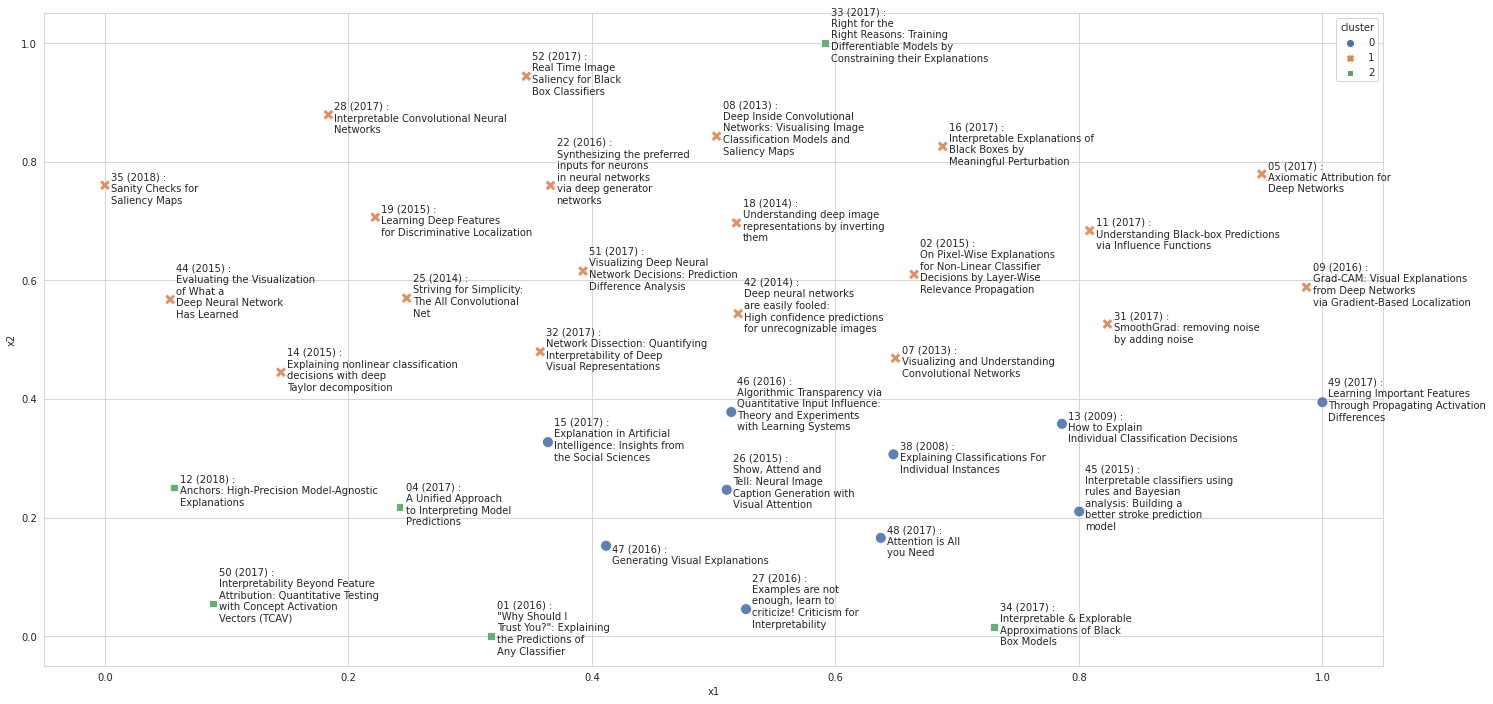

In [99]:
### some articles, like 20 does not cite any other article, so they are not on this graph ###
visualise_clusters(df_tsne_lsa)
# visualise_clusters(df_pca_lsa)

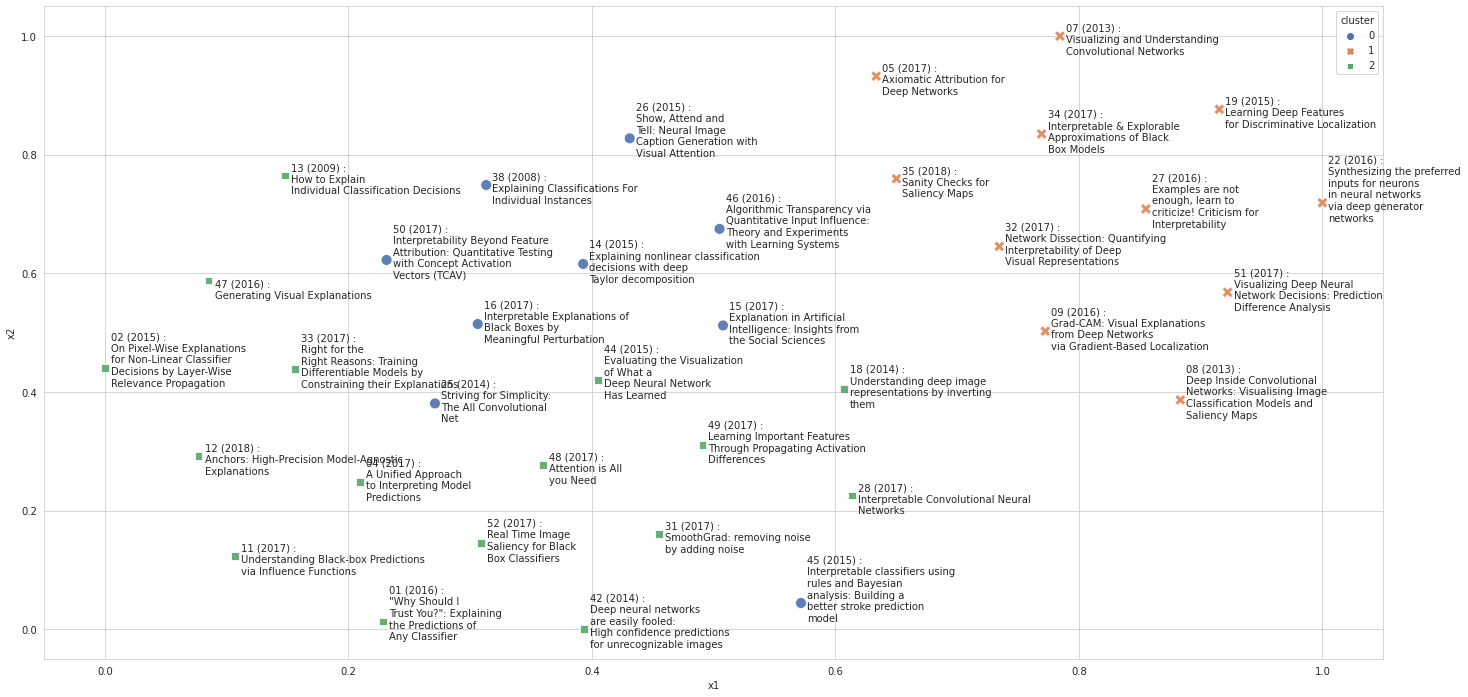

In [142]:
## clustering on BERT emmbedings - not good:
# visualise_clusters(df_tsne_bert)
visualise_clusters(df_tsne_bert_lsa)
# visualise_clusters(df_pca_bert)
# visualise_clusters(df_pca_bert_lsa)

# clustering on both citation data and BERT

/home/mmozolewski/notebooks/xai-survey/clusters-embeddings/df_edges_bert_lsa_and_lsa_tsne.pickle
/home/mmozolewski/notebooks/xai-survey/clusters-embeddings/df_edges_bert_lsa_and_lsa_pca.pickle


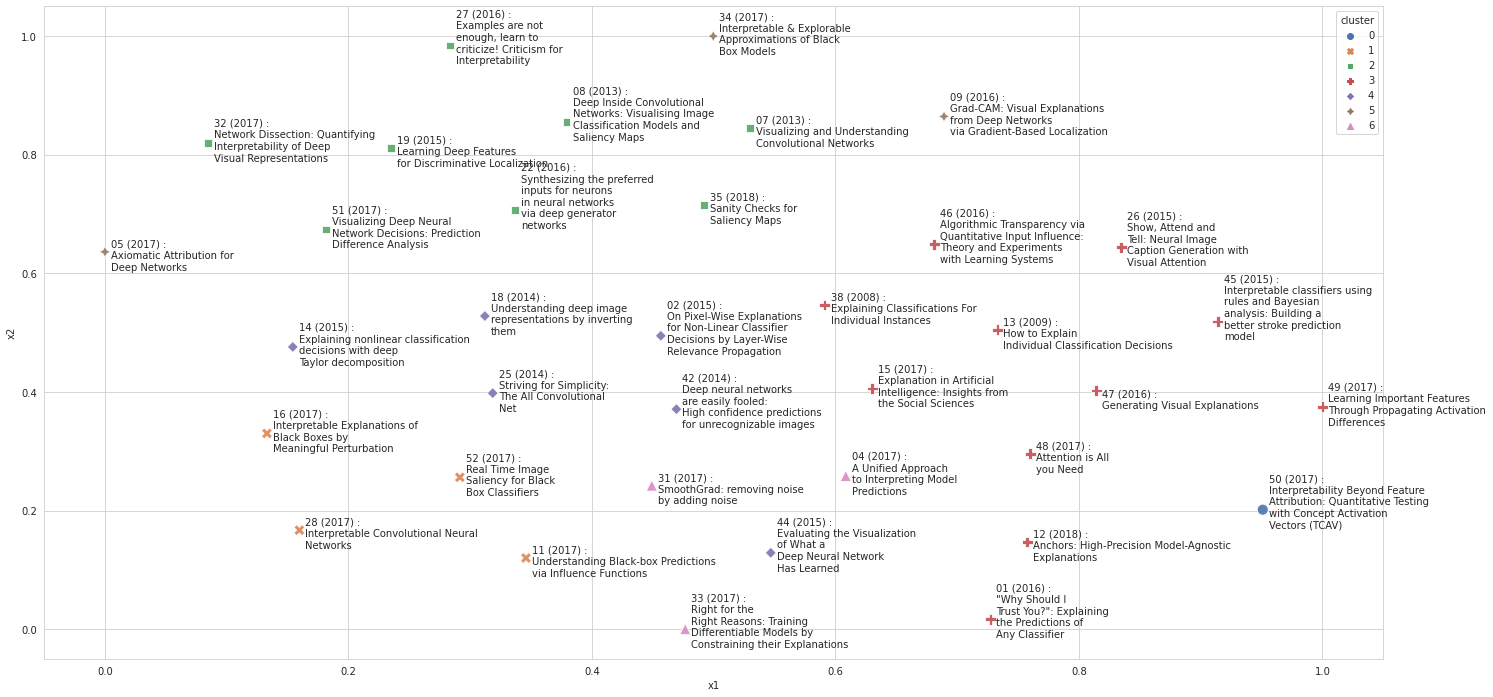

In [151]:
df_edges_bert_lsa_and_lsa = pd.concat([df_edges_bert_lsa, df_edges_lsa.loc[:, (df_edges_lsa.columns != 'article_which_cities') & (df_edges_lsa.columns != 'cluster_kmeans')]], axis=1)
df_edges_bert_lsa_and_lsa = k_means(df_edges_bert_lsa_and_lsa, 'article_which_cities', 7)
df_edges_bert_lsa_and_lsa_tsne, df_edges_bert_lsa_and_lsa_pca = get_TSNE_and_PCA_embeddings(df_edges_bert_lsa_and_lsa, 'article_which_cities')
_save_pandas_pickle(df_edges_bert_lsa_and_lsa_tsne, 'df_edges_bert_lsa_and_lsa_tsne', "notebooks/xai-survey/clusters-embeddings")
_save_pandas_pickle(df_edges_bert_lsa_and_lsa_pca, 'df_edges_bert_lsa_and_lsa_pca', "notebooks/xai-survey/clusters-embeddings")

visualise_clusters(df_edges_bert_lsa_and_lsa_tsne)
# df_edges_bert_lsa_and_lsa_tsne

In [ ]:
# TODO :
#  Zamiast BERT - TF-IDF, W2V
#  clamp -> objnie klustw
# expert clusters from Parisa  -> knAC
# inxai -> dodac NLU, metryki